This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# Title 
#### Team number
- List your group members' name here

In [1]:
# Put all the module import in this code chunk
# webscraping
import requests
import pandas as pd
from bs4 import BeautifulSoup

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model 1
import statsmodels.api as sm

# model 2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


## Introduction

- One or two paragraphs about the background of the project. eg: the backgound of PalWorld and why your analysis can be interesting
- State your research questions. Limit the number of research questions to be one or two.

----

Palworld is a unique survival crafting game that combines creature collection mechanics with base building and combat elements. In Palworld, players can capture, train, and utilize various Pals, each with distinct stats and abilities that affect their performance in different tasks such as combat, resource gathering, and base management. The game's economy includes a pricing system for Pals, which creates an interesting opportunity to analyze what factors drive their market value.

Understanding the relationship between Pal characteristics and their prices has practical implications for players looking to optimize their gameplay strategies. By analyzing data from palworld.gg, a database of all Pals and their attributes, we can investigate which statistical features most strongly influence a Pal's price. Our primary research question is: **Which combination of stats, elemental composition, and rarity levels provides the most accurate prediction of a Pal's market price in the game?"**

This analysis could help players make informed decisions about which Pals to prioritize for capture or breeding, and provide insights into the game's economic balancing mechanics.

-----

## Data 

### Data Source

- List the website you have scraped the data from.
- List which information you have scraped
- Describe what kind of cleaning you have done to the data

-----

**Website Scraped:**

Main Pal listing page (https://palword.gg/pals) and individual Pal detail pages (https://palworld.gg/pal/[pal_name])

**Information Scraped:**

The following attributes were extracted for each Pal:

Name, Rarity, Elements (can have multiple), HP, Defense, Melee Attack, Shot Attack, Crafting Speed, Support, Stamina, Running Speed, Sprinting Speed, Slow Walk Speed, Price, and a direct link to each Pal's detail page

**Data Cleaning Process:**

Several cleaning steps were implemented during the scraping process:

- Type Conversion: Converted numeric stat values from strings to integers where applicable, keeping non-numeric values as strings
- Missing Value Handling: Initialized all stat fields with None values to handle cases where certain stats might be missing from a Pal's page
- Element Formatting: Converted the list of elements for each Pal into a comma-separated string format for easier DataFrame storage
- Data Flattening: Restructured the nested dictionary format (with separate Stats and Elements dictionaries) into a flat structure suitable for pandas DataFrame creation
- Error Handling: Implemented try-except blocks to skip Pals that couldn't be properly scraped, preventing the entire process from failing due to individual page issues
- Standardized Naming: Converted stat names to a consistent format (lowercase with underscores) for uniform column naming in the final DataFrame

-----

### Webscraping and cleaning functions overview

List all the functions you have written for webscraping and data cleaning. For each one, write one sentence to describe it. 
- `extract_soup()`
    - build url and return soup object
- `fetch_pal(url: str) -> BeautifulSoup`
    - Fetches HTML content from a given URL and returns a parsed BeautifulSoup object.
- `parse_pals_data(main_soup: BeautifulSoup) -> list[dict]`
    - Extracts name and detail page links for all Pals from the main listing page.
- `strip_pal_stats(soup: BeautifulSoup) -> dict`
    - Scrapes individual Pal statistics including name, rarity, elements, and various stat values from a Pal's detail page.
- `create_dataframe() -> pd.DataFrame`
    - Orchestrates the entire scraping process by fetching all Pals, extracting their stats, and organizing the data into a pandas DataFrame.

## Webscraping and cleaning

In [2]:
def fetch_pal(url: str) -> BeautifulSoup:
    """
    Args:
        url (str): The inputted url link for a chosen pal

    Returns:
        BeatifulSoup: the parsed content for the given pal
    """
    # first get the link
    resp = requests.get(url)
    # have a checker in the event the input is wrong
    resp.raise_for_status()
    resp = resp.text
    return BeautifulSoup(resp, features="lxml")


def parse_pals_data(main_soup: BeautifulSoup) -> list[dict]:
    """
    Parses Pal data from palworld.gg HTML using BeautifulSoup,
    extracting Name and link to each Pal's detail page.

    Args:
        main_soup (BeautifulSoup): HTML content of the page.

    Returns:
        list[dict]: List of pals with 'Name' and 'Link'.
    """
    pals = []

    # Get the main section
    pals_section = main_soup.find('section', class_='pals-list')
    if not pals_section:
        print("No pals-list section found.")
        return []

    # Each Pal is a div with class "pal"
    pal_divs = pals_section.find_all('div', class_='pal')

    for pal_div in pal_divs:
        try:
            a_tag = pal_div.find('a', href=True)
            if not a_tag:
                continue

            detail_url = a_tag['href']
            full_url = "https://palworld.gg" + detail_url

            name_div = a_tag.find('div', class_='name')
            name = name_div.get_text(strip=True) if name_div else "Unknown"

            pals.append({"Name": name, "Link": full_url})

        except Exception as e:
            print(f"Error parsing pal card: {e}")
            continue

    return pals


def strip_pal_stats(soup: BeautifulSoup) -> dict:
    """
    Extracts individual stats from a Pal's page.

    Args:
        soup(BeautifulSoup): Parsed data from the Pal's page

    Return:
        dict: Dictionary of the stats
    """

    # Retrieve the name of the Pal
    name = soup.find('h1', class_='name').text.strip() if soup.find('h1', class_='name') else None

    # extract the rarity
    rarity_div = soup.find('div', class_='rarity')
    rarity = rarity_div.text.strip() if rarity_div else None

    # Element name
    elements = []
    elements_div = soup.find('div', class_='elements')
    if elements_div:
        elements_divs = elements_div.find_all('div', class_='element')
        for elem_div in elements_divs:
            # this should get the element name
            elem_name = elem_div.find('div', class_='name')
            if elem_name:
                elements.append(elem_name.text.strip())

    # stats
    # Initialize stats dictionary with expected fields
    stats = {
        'name': name,
        'rarity': rarity,
        'hp': None,
        'defense': None,
        'crafting_speed': None,
        'melee_attack': None,
        'shot_attack': None,
        'price': None,
        'stamina': None,
        'support': None,
        'running_speed': None,
        'sprinting_speed': None,
        'slow_walk_speed': None
    }

    stats_div = soup.find('div', class_='stats')
    # reach the stats section
    if stats_div:
        items_divs = stats_div.find_all('div', class_='item')
        # go into each item
        for item in items_divs:
            stat_name_div = item.find('div', class_='name')
            stat_value_div = item.find('div', class_='value')

            # using the name and value of the stats add to the dictionary
            if stat_name_div and stat_value_div:
                stat_name = stat_name_div.text.strip().lower().replace(' ', '_')
                stat_value = stat_value_div.text.strip()
                try:
                    stat_value = int(stat_value)
                except ValueError:
                    pass  # Keep as string if not an int

                if stat_name in stats:
                    stats[stat_name] = stat_value

    return {
        "Name": stats['name'],
        "Rarity": stats['rarity'],
        "Elements": elements,
        "Stats": {
            "HP": stats['hp'],
            "Defense": stats['defense'],
            "Crafting Speed": stats['crafting_speed'],
            "Melee Attack": stats['melee_attack'],
            "Shot Attack": stats['shot_attack'],
            "Support": stats['support'],
            "Stamina": stats['stamina'],
            "Price": stats['price'],
            "Running Speed": stats['running_speed'],
            "Sprinting Speed": stats['sprinting_speed'],
            "Slow Walk Speed": stats['slow_walk_speed'],
        }
    }


def create_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame from the list of Pal data

    Returns:
        DataFrame: Cleaned Dataframe ready for analysis
    """

    main_pal_soup = fetch_pal(BASE_URL)

    # get the basic information
    pals_info = parse_pals_data(main_pal_soup)

    full_data = []
    # loop through the pals
    for idfx, pal in enumerate(pals_info):
        try:
            print(f"Processing {idfx + 1}/{len(pals_info)}: {pal['Name']}")
            detail_soup = fetch_pal(pal["Link"])
            stats = strip_pal_stats(detail_soup)

            # flatten the stats dictionary
            rec = {
                'Name': stats.get('Name'),
                "Link": pal.get("Link"),
                "Rarity": stats['Rarity']
            }

            # add stats (HP, Defense, etc.)
            for key, value in stats.get("Stats", {}).items():
                rec[key] = value
            # add elements as a joined string
            rec["Elements"] = ", ".join(stats.get("Elements", []))

            full_data.append(rec)
        except Exception as e:
            print(f"Skipping {pal.get('Name', '')}: {e}")
            continue

    df = pd.DataFrame(full_data)
    return df

In [3]:
BASE_URL = "https://palworld.gg/pals"

df = create_dataframe()
df.to_csv("test_data1.csv", index=False)
df.head(10)

Processing 1/225: Anubis#100
Processing 2/225: Arsox#42
Processing 3/225: Astegon#98
Processing 4/225: Azurmane#136
Processing 5/225: Azurobe#82
Processing 6/225: Azurobe Cryst#82
Processing 7/225: Bastigor#137
Processing 8/225: Beakon#73
Processing 9/225: Beegarde#50
Processing 10/225: Bellanoir#112
Processing 11/225: Bellanoir Libero#112
Processing 12/225: Blazamut#96
Processing 13/225: Blazamut Ryu#96
Processing 14/225: Blazehowl#84
Processing 15/225: Blazehowl Noct#84
Processing 16/225: Blue Slime#-1
Processing 17/225: Braloha#145
Processing 18/225: Bristla#30
Processing 19/225: Broncherry#86
Processing 20/225: Broncherry Aqua#86
Processing 21/225: Bushi#72
Processing 22/225: Bushi Noct#72
Processing 23/225: Caprity#35
Processing 24/225: Caprity Noct#35
Processing 25/225: Cattiva#2
Processing 26/225: Cave Bat#-1
Processing 27/225: Cawgnito#44
Processing 28/225: Celaray#25
Processing 29/225: Celaray Lux#25
Processing 30/225: Celesdir#132
Processing 31/225: Chikipi#3
Processing 32/22

,Name,Link,Rarity,HP,Defense,Crafting Speed,Melee Attack,Shot Attack,Support,Stamina,Price,Running Speed,Sprinting Speed,Slow Walk Speed,Elements
0,Anubis,https://palworld.gg/pal/anubis,10Epic,120,100,100,130,130,100,100,4960,800,1000,80,Earth
1,Arsox,https://palworld.gg/pal/arsox,4Common,85,95,100,100,95,100,120,3520,700,1050,87,Fire
2,Astegon,https://palworld.gg/pal/astegon,9Epic,100,125,100,100,125,100,300,8200,700,1100,100,"Dragon, Dark"
3,Azurmane,https://palworld.gg/pal/azurmane,7Rare,130,110,100,100,120,100,220,6680,900,1260,90,Electricity
4,Azurobe,https://palworld.gg/pal/azurobe,7Rare,110,100,100,70,100,100,160,5600,600,900,75,"Water, Dragon"
5,Azurobe Cryst,https://palworld.gg/pal/azurobe-cryst,8Epic,115,105,100,100,105,100,160,6720,600,900,75,"Ice, Dragon"
6,Bastigor,https://palworld.gg/pal/bastigor,8Epic,140,120,100,100,130,100,270,9020,750,1100,120,Ice
7,Beakon,https://palworld.gg/pal/beakon,6Rare,105,80,100,100,115,100,160,7490,750,1200,100,Electricity
8,Beegarde,https://palworld.gg/pal/beegarde,4Common,80,90,100,100,90,100,100,1880,450,550,125,Leaf
9,Bellanoir,https://palworld.gg/pal/bellanoir,20Legendary,120,100,100,100,150,100,100,10030,600,800,100,Dark


In [4]:
# Numeric rarity (e.g., from "10Epic" to 10)
df['Num_Rarity'] = df['Rarity'].str.extract(r'(\d+)').astype(int)

# Number of elements (count the elements split by comma)
df['Num_Elements'] = df['Elements'].apply(lambda x: len(x.split(', ')) if isinstance(x, str) else 0)

# Average of stats
stat_cols = ['HP', 'Defense', 'Crafting Speed', 'Melee Attack', 'Shot Attack', 'Support', 'Stamina']
df['Avg_Stats'] = df[['HP', 'Defense', 'Melee Attack', 'Shot Attack', 'Support', 'Stamina']].mean(axis=1)

df.head(10)


,Name,Link,Rarity,HP,Defense,Crafting Speed,Melee Attack,Shot Attack,Support,Stamina,Price,Running Speed,Sprinting Speed,Slow Walk Speed,Elements,Num_Rarity,Num_Elements,Avg_Stats
0,Anubis,https://palworld.gg/pal/anubis,10Epic,120,100,100,130,130,100,100,4960,800,1000,80,Earth,10,1,113.333333
1,Arsox,https://palworld.gg/pal/arsox,4Common,85,95,100,100,95,100,120,3520,700,1050,87,Fire,4,1,99.166667
2,Astegon,https://palworld.gg/pal/astegon,9Epic,100,125,100,100,125,100,300,8200,700,1100,100,"Dragon, Dark",9,2,141.666667
3,Azurmane,https://palworld.gg/pal/azurmane,7Rare,130,110,100,100,120,100,220,6680,900,1260,90,Electricity,7,1,130.000000
4,Azurobe,https://palworld.gg/pal/azurobe,7Rare,110,100,100,70,100,100,160,5600,600,900,75,"Water, Dragon",7,2,106.666667
5,Azurobe Cryst,https://palworld.gg/pal/azurobe-cryst,8Epic,115,105,100,100,105,100,160,6720,600,900,75,"Ice, Dragon",8,2,114.166667
6,Bastigor,https://palworld.gg/pal/bastigor,8Epic,140,120,100,100,130,100,270,9020,750,1100,120,Ice,8,1,143.333333
7,Beakon,https://palworld.gg/pal/beakon,6Rare,105,80,100,100,115,100,160,7490,750,1200,100,Electricity,6,1,110.000000
8,Beegarde,https://palworld.gg/pal/beegarde,4Common,80,90,100,100,90,100,100,1880,450,550,125,Leaf,4,1,93.333333
9,Bellanoir,https://palworld.gg/pal/bellanoir,20Legendary,120,100,100,100,150,100,100,10030,600,800,100,Dark,20,1,111.666667


### Data overview

-----
**Sample Data:**

Cleaned data preview is shown above.

**Target Variable:**

Price is our target variable, ranging from 1,000 to 24,900 (mean: 4,535)
All 225 Pals have price values (no missing data)

**Feature Summary:**

Combat Stats: HP (60-150), Defense (50-145), Melee Attack (50-150), Shot Attack (50-150)

Utility Stats: All Pals have Crafting Speed of 100, Support mostly at 100 (range: 30-150)

Movement Stats: Running Speed (240-2000), Sprinting Speed has 2 anomalous negative values

Categorical: Rarity levels from 1Common to 20Legendary; 9 element types with 72% of Pals having single element

**Columns Added**

Num_Rarity: The number of rarity categories associated with each Pal, based on its listed rarities. This feature helps analyze whether Pals with more rarity types tend to be priced higher, explored through a bar chart of average Price by Num_Rarity.

Num_Elements: The number of elemental types associated with each Pal, based on its listed elements. This feature investigates if Pals with more elements command higher or more variable prices, examined using a boxplot of Price by Num_Elements

Avg_Stats: The average of all individual stat values for each Pal, giving a standardized measure of overall performance. This feature is used to explore how a Pal's overall strength influences its price, shown via a scatterplot relating Avg_Stats to Price.



**Potential Data Issues:**

- No data on skills/abilities, work suitability, food consumption, or capture difficulty - which could significantly impact price
- 2 Pals have negative Sprinting Speed values (-1), suggesting data collection errors
- Crafting Speed is constant at 100 for all Pals, providing no predictive value
- Only 8 Legendary Pals vs 30+ Common ones could affect model performance

-----

## Visualizations

### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `make_hist()`
    - Generate a histogram with given data and feature
 
### Visualization results
- Present 3-4 data visualizations.
- For each visualization, you need to include title, xlabel, ylabel, legend (if necessary)
- For each visualization, explain why you make this data visualization (how it related to your research question) and explain what you have learned from this visualization

In [5]:
def scatterplot(*args, **kwargs):
    """
    Draw a scatterplot with given data and features.

    :param args: Positional arguments (rarely used, usually empty)
    :param kwargs: Keyword arguments including:
        - x (str or array-like): Name of the column or array for x-axis
        - y (str or array-like): Name of the column or array for y-axis
        - data (DataFrame): DataFrame containing the data
        - hue, palette, title, xlabel, ylabel, legend, etc.
    :return: matplotlib.axes.Axes object containing the scatterplot
    """


def boxplot(*args, **kwargs):
    """
    Draw a box plot to show distributions with respect to categories.

    :param args: Positional arguments (rarely used, usually empty)
    :param kwargs: Keyword arguments including:
        - x (str or array-like): Name of the column or array for x-axis
        - y (str or array-like): Name of the column or array for y-axis
        - data (DataFrame): DataFrame containing the data
        - hue, palette, title, xlabel, ylabel, legend, etc.
    :return: matplotlib.axes.Axes object containing the box plot
    """


def barplot(*args, **kwargs):
    """
    Draw a bar plot to compare aggregated numeric values across categories.

    :param args: Positional arguments (rarely used, usually empty)
    :param kwargs: Keyword arguments including:
        - x (str or array-like): Name of the column or array for x-axis
        - y (str or array-like): Name of the column or array for y-axis
        - data (DataFrame): DataFrame containing the data
        - estimator (function): Aggregation function, e.g., np.mean
        - palette, title, xlabel, ylabel, legend, etc.
    :return: matplotlib.axes.Axes object containing the bar plot
    """

### Visualization Functions Overview

- scatterplot:
    - Creates a scatterplot to visualize relationships between two continuous variables with optional styling
- boxplot:
    - Generates a boxplot to display the distribution and spread of data across categorical groups.
- barplot:
    - Produces a bar chart to compare aggregated numerical values across different categories.

#### Visualization 1: Avg_Stats vs Price (Scatterplot)

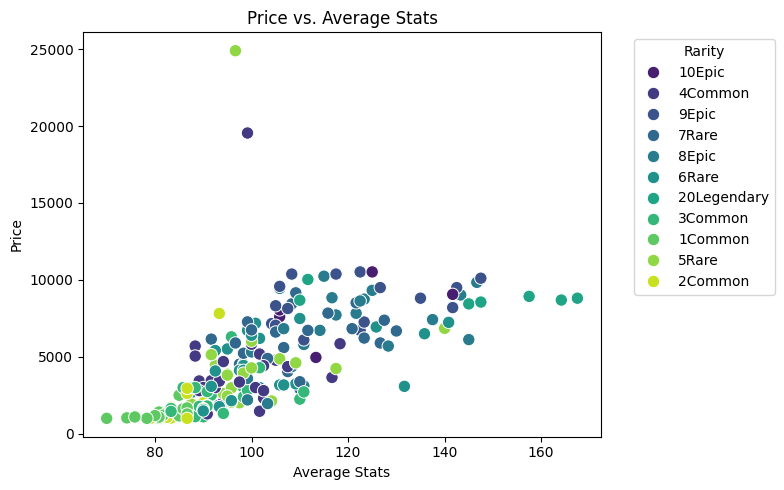

In [6]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Avg_Stats', y='Price', data=df, hue='Rarity', palette='viridis', s=80)
plt.title('Price vs. Average Stats')
plt.xlabel('Average Stats')
plt.ylabel('Price')
plt.legend(title='Rarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Interpretation

**Why this visualization was made**

This scatterplot was created to examine how a Pal's average stats and rarity level interact to influence price. Since the research question asks which combination of stats, elemental composition, and rarity levels most strongly predicts price, this plot helps to identify whether certain stat-rarity parings consistently result in higher prices, and whether outliers suggest an added influence from elemental composition.

**What we learned**

There is a clear positive correlation between average stats and price. Pals with average stats in the 80-100 range typically sell for under 5,000, while those in the 120-140 range often reach 8,000-10,000. The highest state range (160+) still commands prices of around 9,000 to 10,000. A notable outlier, with stats near 100 but priced over 25,000, suggests that additional traits-such as duel-elemental composition-can significantly elevate price value. This supports the idea that high stats combined with high rarity are strong predictors of high price, but the highest prices may result from the combined effect of all three factors.





#### Visualization 2: Average Price vs. Num_Rarity (Bar Graph)

/var/folders/lx/l9dwg8ts60b2hfv6c5ws6_1w0000gn/T/ipykernel_6889/2979009827.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Num_Rarity', y='Price', data=avg_price_rarity, palette='coolwarm')


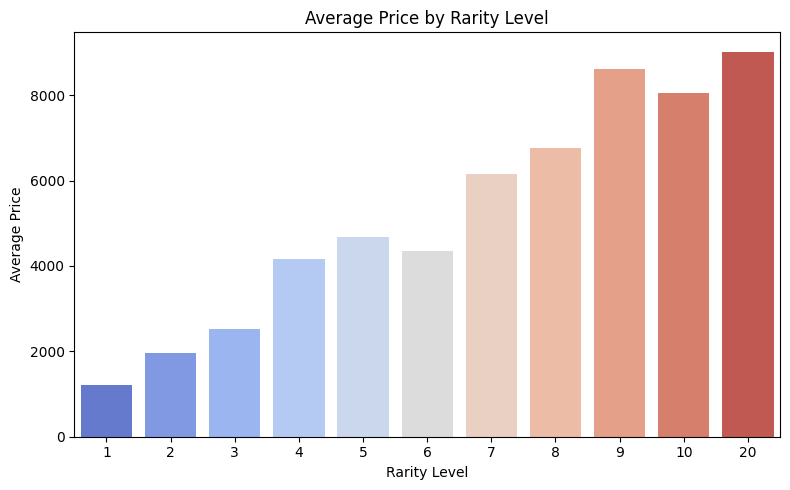

In [7]:
avg_price_rarity = df.groupby('Num_Rarity')['Price'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Num_Rarity', y='Price', data=avg_price_rarity, palette='coolwarm')
plt.title('Average Price by Rarity Level')
plt.xlabel('Rarity Level')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()


### Interpretation

**Why this visualization was made**

This barplot isolates rarity to assess its standalone effect before combining it with stats and elemental composition in later predictive modeling. This is critical for our research question because if rarity alone explains large price differences, it is likely to be a dominant factor in the most valuable combinations.

**What we learned**

Average price increases steadily with rarity level. At rarity level 1, the average price is about 1,200. By rarity level 4, it rises to 4,300, and by level 7 it reaches 6,200. The highest prices occur at rarity levels 9(~8,500), 10(~8,000), and 20(~8,900). This is a 7x increase from the lowest to the highest rarity. These results confirm that rarity alone is a major driver of price, and when paired with high stats and certain elemental compositions, it is likely to form part of the strongest predictive combination.

#### Visualization 3: Num_Elements vs Price (Box Plot)

/var/folders/lx/l9dwg8ts60b2hfv6c5ws6_1w0000gn/T/ipykernel_6889/2714639348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Num_Elements', y='Price', data=df, palette='magma')


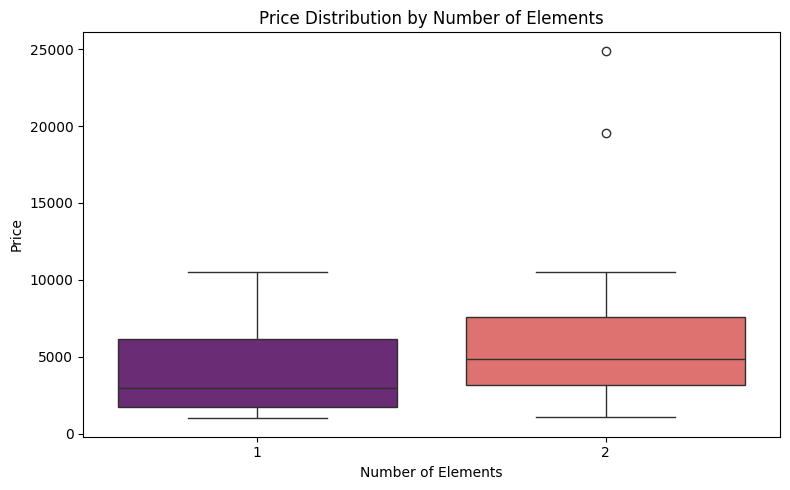

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Num_Elements', y='Price', data=df, palette='magma')
plt.title('Price Distribution by Number of Elements')
plt.xlabel('Number of Elements')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

### Interpretation

**Why this visualization was made**

This boxplot tests whether different elemental compositions impact price and provides insight into how this factor may enhance the effects of stats and rarity in predicting high-value Pals. Understanding this relationship is important for our research question because elemental composition could be the factor that pushes certain stat–rarity combinations into the highest price ranges.

**What we learned**

Pals with single-element composition have a median price of 5,000, with most prices between 2,500 and 9,000. Rare outliers exceed 20,000. Pals with dual-element composition have a higher median price of 6,000 and a broader range of 3,500–10,000. This group also contains the highest price observed (over 25,000). While elemental composition alone is not as strong a predictor as rarity or stats, it appears to magnify price when combined with high values in the other two variables, making it an important component of top-tier combinations.

## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering. 

In [9]:
# list all the functions you have for modeling. Make sure write full 
# docstrings for each function
def fit_linear(df, y_feat, x_feat):
    pass

#### Model 1: Multiple Linear Regression

In [10]:
# Running the model

# Log-transform the target
y_log = np.log(df['Price'])

# Prepare predictors
X = df[['Avg_Stats', 'Num_Rarity', 'Num_Elements']]

# Adding constant
X = sm.add_constant(X)

# Fitting model
model_log = sm.OLS(y_log, X).fit()

# Printing summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     112.2
Date:                Tue, 12 Aug 2025   Prob (F-statistic):           3.53e-44
Time:                        23:23:44   Log-Likelihood:                -147.47
No. Observations:                 225   AIC:                             302.9
Df Residuals:                     221   BIC:                             316.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7027      0.232     24.616   

### Interpretation of Coefficients (Full Data)

Model:

ln(Price) = 5.7027 + 0.0177 * Avg_Stats + 0.0736 * Num_Rarity + 0.2008 * Num_Elements

- **Avg_Stats (0.0177)**

    Holding rarity and elements constant, each +1 increase in average stats increses the predicted price by about **1.78%**
    Example: +10 stat points is around a **17.8%** increase in price

- Num_Rarity (0.0736)

    Holding stats and elements constant, each +1 rarity level increases the predicted price by about **7.64%**
    Example: Rarity 10 vs. rarity 5 is around a **32.8%** increase in price

- Num_Elements (0.2008)

    Holding stats and rarity constant, switching from single-element to dual-element increases the predicted price by about **22.2%**

### Residual Plot

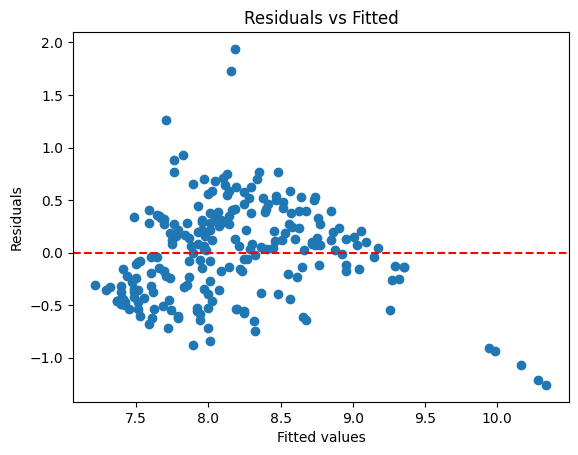

In [11]:
fitted_vals = model_log.fittedvalues
residuals = model_log.resid

plt.scatter(fitted_vals, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

### Actual vs. Predicted Price

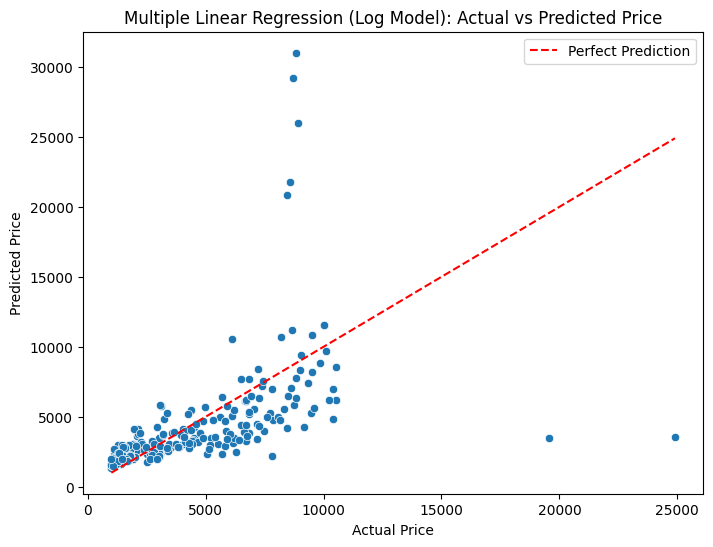

In [12]:
# Predicted log prices from model
predicted_log = model_log.predict(X)

# Convert back to actual prices
df['Predicted_Price'] = np.exp(predicted_log)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Predicted_Price', data=df)
plt.plot([df['Price'].min(), df['Price'].max()],
         [df['Price'].min(), df['Price'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Multiple Linear Regression (Log Model): Actual vs Predicted Price')
plt.legend()
plt.show()

#### Model 2

Random Forest Model Results:
Cross-validated R²: 0.492 (± 0.212)
Cross-validated RMSE: 2380


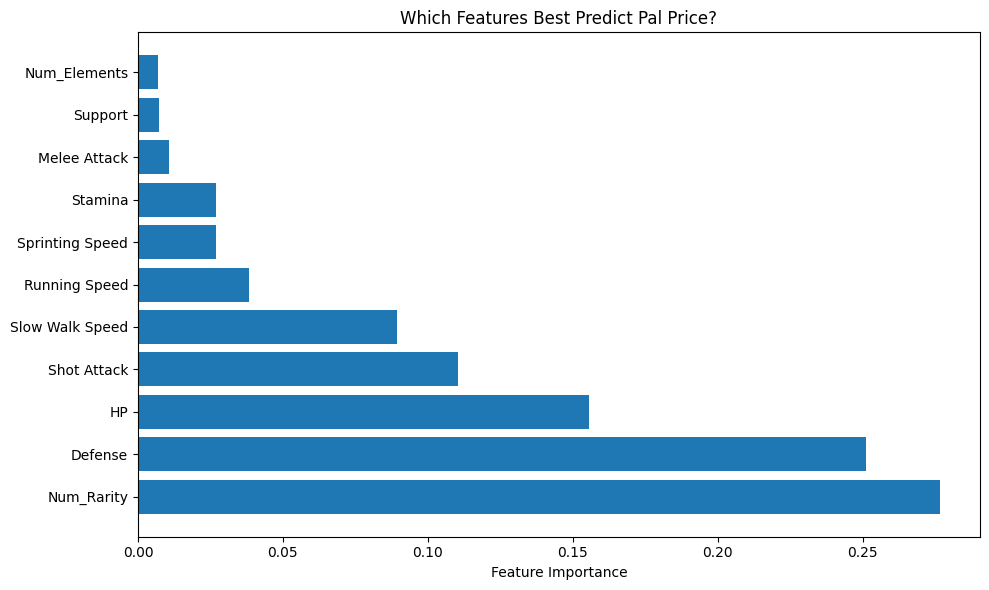


Top 3 Most Important Features for Predicting Price:
1. Num_Rarity: 0.277
2. Defense: 0.251
3. HP: 0.155


In [14]:
# Model 2: Random Forest Regressor

# use individual stats to see which specific stats matter most
feature_cols = ['HP', 'Defense', 'Melee Attack', 'Shot Attack', 'Support',
                'Stamina', 'Running Speed', 'Sprinting Speed', 'Slow Walk Speed',
                'Num_Rarity', 'Num_Elements']

X = df[feature_cols]
y = df['Price']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    random_state=1  # need to set this so that its deterministic
)

# fit and predict
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# calculate R^2 and MSE with cross-validation
cv_r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_mse_scores = -cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

print("Random Forest Model Results:")
print(f"Cross-validated R²: {cv_r2_scores.mean():.3f} (± {cv_r2_scores.std():.3f})")
print(f"Cross-validated RMSE: {np.sqrt(cv_mse_scores.mean()):.0f}")

# Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Which Features Best Predict Pal Price?')
plt.tight_layout()
plt.show()

# print most important features
print("\nTop 3 Most Important Features for Predicting Price:")
for i in range(3):
    print(f"{i + 1}. {feature_importance.iloc[i]['feature']}: {feature_importance.iloc[i]['importance']:.3f}")

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?
- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.